In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),nu=0.1))

    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    plt.show()

In [4]:
def get_RF_feature_importance():
    features= X
    feature_list = list(features.columns)
    rf = RandomForestRegressor(n_estimators= 15, random_state=1)
    rf.fit(X , Y)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)      
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, 
                           importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [5]:
data = pd.read_csv('sisso_out.csv' , encoding='cp1252')   

In [6]:
data_std=data.copy()
#data_std[columns]= StandardScaler().fit_transform(data[columns])
Y = data_std['Target'] 
X = data.drop(['Target'], axis=1)

In [7]:
corrmat = X.corr()
top_corr_features = corrmat.index
correlated_features = set()
#plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn" )

In [8]:
for i in range(len(X.columns)):
    for j in range(i):
        if abs(corrmat.iloc[i, j]) > 0.9:
            colname = corrmat.columns[i]
            correlated_features.add(colname)
len(correlated_features)
print(correlated_features)

set()


In [9]:
data_std.drop(labels=correlated_features, axis=1, inplace=True)
data_std.shape
Y = data_std['Target'] 
X = data_std.drop(['Target'], axis=1)

### Test-train splitting 

In [10]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.9, 
                                     test_size = 0.1, 
                                     random_state = 100)

# divide into X_train, y_train, X_test, y_test
y_train = df_train.pop('Target')
X_train = df_train

y_test = df_test.pop('Target')
X_test = df_test

In [11]:
# Instantiate random forest and train on new features
rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
lr = LinearRegression()
rr = Ridge(alpha=0.01)
lasso = Lasso(alpha=0.01)

models = [rf,lr,rr,lasso]
models_names = ["RF","LR","RR","LASSO"]
r2scores=[]
rmse=[]
count=0
for model in models :
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2=sklearn.metrics.r2_score(y_test, y_pred)
    err=np.sqrt(mean_squared_error(y_test,y_pred))
    r2scores.append(r2)
    rmse.append(err)
    print(models_names[count])
    print("R2: ",r2)
    print("RMSE: ",err)
    print("----------------------------------------")
    count+=1

RF
R2:  0.7283879648334274
RMSE:  0.08387069824484981
----------------------------------------
LR
R2:  0.9509059920896553
RMSE:  0.035657426684733
----------------------------------------
RR
R2:  0.9468764759739379
RMSE:  0.03709190956443271
----------------------------------------
LASSO
R2:  0.5009949555007693
RMSE:  0.1136810880993307
----------------------------------------


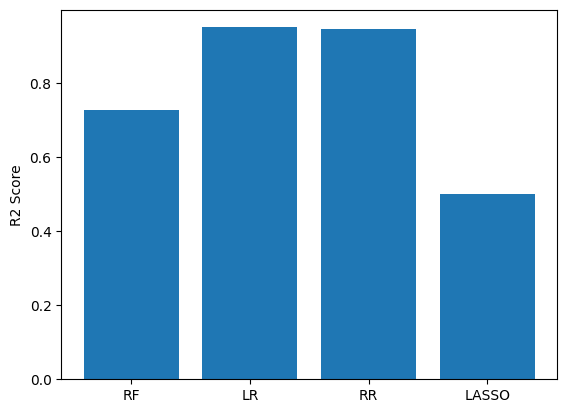

In [12]:
plt.rcdefaults()
fig, ax = plt.subplots()

x_pos = np.arange(len(models_names))
ax.bar(x_pos, r2scores, align='center')
ax.set_xticks(x_pos)
ax.set_xticklabels(models_names)
ax.set_ylabel('R2 Score')
#plt.savefig('imp.eps', format='eps')
plt.show()

### Using CV technique

RF
R2:  0.7925939562380326
RMSE:  0.08381383009768294
---------------------------------------
GB
R2:  0.6486734246428651
RMSE:  0.10908385685125356
---------------------------------------
LR
R2:  0.9678104001882195
RMSE:  0.03301891303048117
---------------------------------------
RR
R2:  0.9621519812887293
RMSE:  0.03580358862129128
---------------------------------------
LASSO
R2:  0.46433733134053334
RMSE:  0.13469475167116476
---------------------------------------
gpr1
R2:  0.9676241991589574
RMSE:  0.03311427442413728
---------------------------------------
gpr2
R2:  -0.17690960001243639
RMSE:  0.1996533199634486
---------------------------------------
gpr3
R2:  -1.7521357153870718
RMSE:  0.3053092109230009
---------------------------------------
gpr4
R2:  -1.7521354068399186
RMSE:  0.30530919380860316
---------------------------------------
gpr5
R2:  0.25107392463860856
RMSE:  0.15926650852380514
---------------------------------------
gpr6
R2:  -0.39260369710610554
RMSE:  0.217

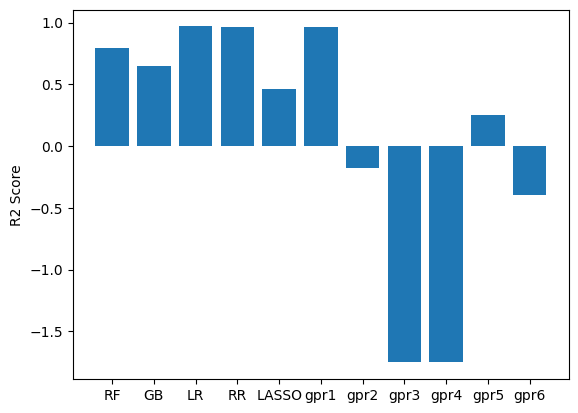

In [13]:
run_models()

## Feature selection


In [ ]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=7)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(7,'Score'))  #print 10 best features

In [ ]:
run_models()

In [ ]:
featureScores.nlargest(50,'Score')['Feature'].values

In [ ]:
X=X[['1', '3', '6', '15', '26', '28', '82', '34', '81', '118', '33',
       '89', '27', '97', '91', '93', '86', '119', '24', '85', '88', '23',
       '123', '21', '131', '73', '99', '55', '75', '56', '36', '90', '94',
       '84', '108', '43', '49', '115', '101', '103', '50', '107', '130',
       '22', '109', '35', '122', '102', '125', '76']]

In [ ]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

In [ ]:
featureScores.nlargest(30,'Score')['Feature'].values

In [ ]:
X=X[['1', '3', '6', '15', '26', '28', '82', '34', '81', '118', '33',
       '89', '27', '97', '91', '93', '86', '119', '24', '85', '88', '23',
       '123', '21', '131', '73', '99', '55', '75', '56']]

In [ ]:
run_models()

In [ ]:
featureScores.nlargest(20,'Score')['Feature'].values

In [ ]:
X=X[['1', '3', '6', '15', '26', '28', '82', '34', '81', '118', '33',
       '89', '27', '97', '91', '93', '86', '119', '24', '85']]

In [ ]:
get_RF_feature_importance()

In [ ]:
run_models()

In [ ]:
featureScores.nlargest(10,'Score')['Feature'].values

In [ ]:
X=X[['1', '3', '6', '15', '26', '28', '82', '34', '81', '118']]

In [ ]:
run_models()